En este notebook se desarrollan los gráficos que se usarán en la parte de resultados del TFM

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets import daocensus, daocensus_text, to_microsoft
from src import paths

In [2]:
ORG_NAME = 'Decentraland'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES: bool = False
CUTOFF_DATE_STR = "2023-07-29"
LAST_SPLITS = ... # Wont be used

SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE: bool = True

In [3]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

# Exploración de datos de Decentraland

In [4]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, ORG_PLATFORM)
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
# dfp = dfp.set_index('id')
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES, cutoff_date=CUTOFF_DATE)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  category      
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 8.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1942 entries, 77517de0-67cb-52f1-9505-c38f14df247c to 5e3a1b69-d42b-5a05

## Cuantas propuestas tenemos para entrenar en el dataset

In [5]:
from src.model_selection import timeFreqSplitCurrent, filter_current
from collections import defaultdict

In [6]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(10)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

t
2023-05-11    106129
2023-05-18    107387
2023-05-25    108802
2023-06-01    109556
2023-06-08    110250
2023-06-15    111195
2023-06-22    112105
2023-06-29    112925
2023-07-06    114417
2023-07-13    115984
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2023-W19,18,1627,358,90.39,4.54,354,139,19.67,2.55
2023-W20,25,1346,305,53.84,4.41,811,169,32.44,4.80
2023-W21,19,1483,305,78.05,4.86,332,122,17.47,2.72
2023-W22,13,819,247,63.00,3.32,289,101,22.23,2.86
2023-W23,13,631,191,48.54,3.30,341,118,26.23,2.89
2023-W24,16,872,225,54.50,3.88,391,132,24.44,2.96
2023-W25,17,1136,278,66.82,4.09,360,148,21.18,2.43
2023-W26,10,838,278,83.80,3.01,239,107,23.90,2.23
2023-W27,21,1591,469,75.76,3.39,890,249,42.38,3.57


In [7]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2023-W19 & 18 & 1627 & 358 & 90.39 & 4.54 & 354 & 139 & 19.67 & 2.55 \\
2023-W20 & 25 & 1346 & 305 & 53.84 & 4.41 & 811 & 169 & 32.44 & 4.80 \\
2023-W21 & 19 & 1483 & 305 & 78.05 & 4.86 & 332 & 122 & 17.47 & 2.72 \\
2023-W22 & 13 & 819 & 247 & 63.00 & 3.32 & 289 & 101 & 22.23 & 2.86 \\
2023-W23 & 13 & 631 & 191 & 48.54 & 3.30 & 341 & 118 & 26.23 & 2.89 \\
2023-W24 & 16 & 872 & 225 & 54.50 & 3.88 & 391 & 132 & 24.44 & 2.96 \\
2023-W25 & 17 & 1136 & 278 & 66.82 & 4.09 & 360 & 148 & 21.18 & 2.43 \\
2023-W26 & 10 & 838 & 278 & 83.80 & 3.01 & 239 & 107 & 23.90 & 2.23 \\
2023-W27 & 21 & 1591 & 469 & 75.76 & 3.39 & 890 & 249 & 42.38 & 3.57 \\
2023-W28

In [8]:
sdf.describe()

,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,17.500000,1892.600000,110875.000000,1283.600000,325.600000,439.100000,6986.300000,142.700000,72.309672,3.896316,24.663246,2.972483
std,4.719934,33.002357,3083.717454,552.792949,123.245194,222.144322,117.242436,42.426538,18.695872,0.618609,7.715053,0.735661
min,10.000000,1838.000000,106129.000000,631.000000,191.000000,239.000000,6863.000000,101.000000,48.538462,3.014388,16.695652,2.233645
25%,13.750000,1870.250000,108990.500000,846.500000,254.750000,334.250000,6912.500000,119.000000,56.625000,3.334923,20.044118,2.586128
50%,17.500000,1893.000000,110722.500000,1241.000000,291.500000,357.000000,6946.000000,135.500000,71.292717,3.980943,23.065385,2.791349
75%,20.500000,1913.500000,112720.000000,1564.000000,344.750000,389.250000,7028.250000,146.500000,82.363158,4.348586,25.782452,2.944049
max,25.000000,1941.000000,115984.000000,2493.000000,600.000000,890.000000,7234.000000,249.000000,108.391304,4.862295,42.380952,4.798817


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2023-W19'),
  Text(1, 0, '2023-W20'),
  Text(2, 0, '2023-W21'),
  Text(3, 0, '2023-W22'),
  Text(4, 0, '2023-W23'),
  Text(5, 0, '2023-W24'),
  Text(6, 0, '2023-W25'),
  Text(7, 0, '2023-W26'),
  Text(8, 0, '2023-W27'),
  Text(9, 0, '2023-W28')])

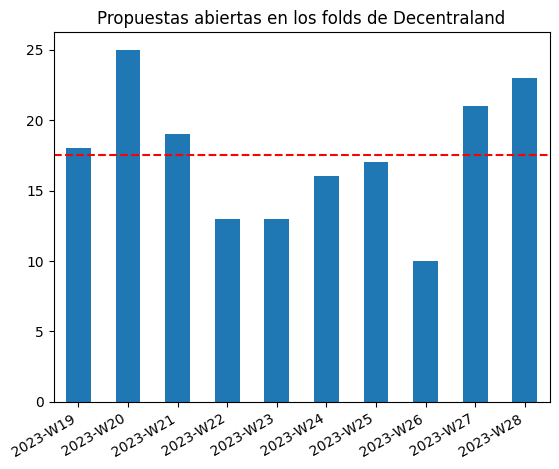

In [9]:
ax = sdf[['open proposals']].plot.bar(legend=False, xlabel='')
plt.axhline(sdf['open proposals'].mean(), c='red', linestyle='--')
ax.set_title(f'Propuestas abiertas en los folds de {ORG_NAME}')
ax.set_xticklabels(sdf.index.strftime('%G-W%V'))
plt.xticks(rotation=30, ha='right')
# TODO: Pintar horizonte con la media

<Axes: xlabel='t'>

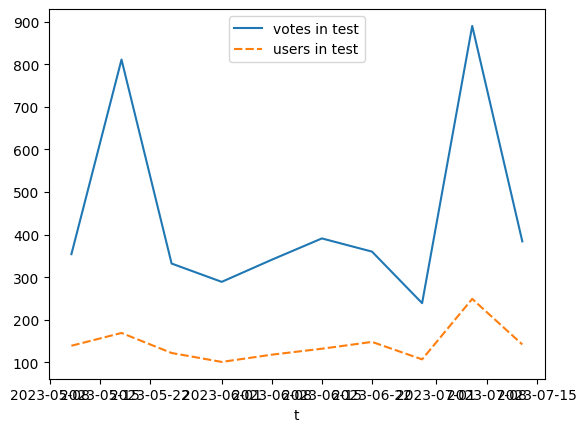

In [10]:
sns.lineplot(sdf[[
    # 'users in train (filtered)', 'votes in train (filtered)', 
    'votes in test', 'users in test',
]])

### Numero de propuestas relevantes
Además del número de propuestas abiertas, queremos saber cual es la _precision@k_ máxima, para ello es necesario saber no sólo el número de propuestas abiertas, si no en cuantas de esas propuestas votaron los usuarios. En términos de IR, necesitamos saber cual es el número de documentos relevantes, que seguramente sea menor que el número de documentos recuperados.

In [11]:
sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']
sdf

/tmp/ipykernel_881640/710207913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']


,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test,vpu in test
t,,,,,,,,,,,,,
2023-05-11,18,1838,106129,1627,358,354,6863,139,90.388889,4.544693,19.666667,2.546763,2.546763
2023-05-18,25,1859,107387,1346,305,811,6886,169,53.840000,4.413115,32.440000,4.798817,4.798817
2023-05-25,19,1868,108802,1483,305,332,6910,122,78.052632,4.862295,17.473684,2.721311,2.721311
2023-06-01,13,1877,109556,819,247,289,6920,101,63.000000,3.315789,22.230769,2.861386,2.861386
2023-06-08,13,1886,110250,631,191,341,6937,118,48.538462,3.303665,26.230769,2.889831,2.889831
2023-06-15,16,1900,111195,872,225,391,6955,132,54.500000,3.875556,24.437500,2.962121,2.962121
2023-06-22,17,1909,112105,1136,278,360,6987,148,66.823529,4.086331,21.176471,2.432432,2.432432
2023-06-29,10,1915,112925,838,278,239,7042,107,83.800000,3.014388,23.900000,2.233645,2.233645
2023-07-06,21,1933,114417,1591,469,890,7129,249,75.761905,3.392324,42.380952,3.574297,3.574297


# Recomendador GNN

In [12]:
dfh = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE))
dfg = dfh[dfh['model'] == 'gnn'].reset_index(drop=True)
dfg

,t,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model
0,2023-05-11,-,0.416377,0.352059,0.509875,0.424959,0.191367,0.241727,0.716831,0.486346,gnn
1,2023-05-18,-,0.279797,0.212740,0.382180,0.347597,0.244970,0.291124,0.438620,0.295328,gnn
2,2023-05-25,-,0.368294,0.308443,0.474747,0.404854,0.185246,0.239344,0.686419,0.480092,gnn
3,2023-06-01,-,0.455673,0.354269,0.574274,0.445985,0.254455,0.320792,0.842604,0.509346,gnn
4,2023-06-08,-,0.443572,0.350776,0.568867,0.459688,0.251695,0.311864,0.855579,0.551402,gnn
5,2023-06-15,-,0.421821,0.346683,0.540205,0.456464,0.231818,0.296970,0.762172,0.527457,gnn
6,2023-06-22,-,0.363104,0.285812,0.482499,0.355483,0.185135,0.213514,0.776511,0.407508,gnn
7,2023-06-29,-,0.497451,0.408432,0.635743,0.508310,0.223364,0.314019,1.000000,0.674410,gnn
8,2023-07-06,-,0.319695,0.241315,0.451723,0.369829,0.222490,0.247390,0.647752,0.394219,gnn
9,2023-07-13,-,0.327272,0.263421,0.460236,0.368104,0.180986,0.212676,0.689917,0.440845,gnn


# Recomendador Híbrido

In [13]:
from src import baseline

# dfm_baseline = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_baseline = baseline.read_metrics_baseline(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date = CUTOFF_DATE)
dfm_baseline['model'] = 'mp'
dfm_all = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)).set_index('t')
dfm_all = pd.concat((dfm_all, dfm_baseline))
dfm_all

,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model,precision@15,ndcg@15,map@15,recall@15
t,,,,,,,,,,,,,,
2023-05-11,avg,0.429496,0.407901,0.530501,0.493268,0.192806,0.269065,0.748986,0.577288,hybrid,NaN,NaN,NaN,NaN
2023-05-18,avg,0.294808,0.254201,0.417307,0.415730,0.283432,0.350296,0.535644,0.362362,hybrid,NaN,NaN,NaN,NaN
2023-05-25,avg,0.413105,0.328756,0.521348,0.423864,0.196721,0.247541,0.736614,0.478115,hybrid,NaN,NaN,NaN,NaN
2023-06-01,avg,0.528660,0.438226,0.623661,0.531954,0.253465,0.352475,0.830228,0.577738,hybrid,NaN,NaN,NaN,NaN
2023-06-08,avg,0.552511,0.429311,0.650247,0.524039,0.251695,0.315254,0.859463,0.581487,hybrid,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14 22:25:09,NaN,0.294001,0.231140,0.376836,0.290950,0.184848,0.213636,0.543728,0.315266,mp,0.185354,0.494567,0.352634,0.903851
2023-06-21 23:50:36,NaN,0.286150,0.240828,0.356482,0.300084,0.143919,0.183784,0.488397,0.327366,mp,0.136036,0.438371,0.321896,0.755448
2023-06-28 21:57:25,NaN,0.422290,0.305020,0.575084,0.371796,0.223364,0.228037,1.000000,0.454473,mp,0.148910,0.575084,0.422290,1.000000
